<a href="https://colab.research.google.com/github/Elixirman/my_HYE_Works/blob/main/Michaelz_Kaggle_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# About

you will build artificial intelligence algorithms to label satellite image chips with different atmospheric conditions and the different classes of land cover/land use.  For this Multi-class Multi-Label problem, some of the labels are from the following categories: Cloud Cover (clear, partly, cloudy, haze), Primary RainForest, Water (rivers, lakes), Habitation (large city, small homes), Agriculture, Roads etc. The algorithms from this project will enable us to understand where, how and why deforestation happens.

# Dependencies

In [13]:
# Standard Libraries
import os
import time
import warnings

# Data Manipulation and Analysis
import pandas as pd
import numpy as np

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Image Processing
import cv2

# Machine Learning and Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
from skimage.io import imread

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Model Evaluation
from sklearn.metrics import fbeta_score


# Filter warnings
warnings.filterwarnings('ignore')


# Data Importation

In [2]:
train_df = pd.read_csv('/content/train_v2.csv')
sample_submission_df = pd.read_csv('/content/sample_submission_v2.csv')
test_mapping_df = pd.read_csv('/content/test_v2_file_mapping.csv')

# EDA

## Data Head

In [3]:
train_df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [ ]:
test_mapping_df.head()

,old,new
0,file_4158.tif,file_18830.tif
1,file_1668.tif,file_19164.tif
2,file_2411.tif,file_15749.tif
3,file_16047.tif,file_7531.tif
4,file_1271.tif,file_18347.tif


In [ ]:
sample_submission_df.head()

,image_name,tags
0,test_0,primary clear agriculture road water
1,test_1,primary clear agriculture road water
2,test_2,primary clear agriculture road water
3,test_3,primary clear agriculture road water
4,test_4,primary clear agriculture road water


## Shape

In [4]:
# Training Data Shape
print(f'Training Data Shape: {train_df.shape}')

Training Data Shape: (40479, 2)


## Info

In [ ]:
# Training Data info
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40479 entries, 0 to 40478
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_name  40479 non-null  object
 1   tags        40479 non-null  object
dtypes: object(2)
memory usage: 632.6+ KB


## De-Stats

In [ ]:
# Descriptive Statistics
train_df.describe()

,image_name,tags
count,40479,40479
unique,40479,449
top,train_0,clear primary
freq,1,13636


## Distribution Label Visual

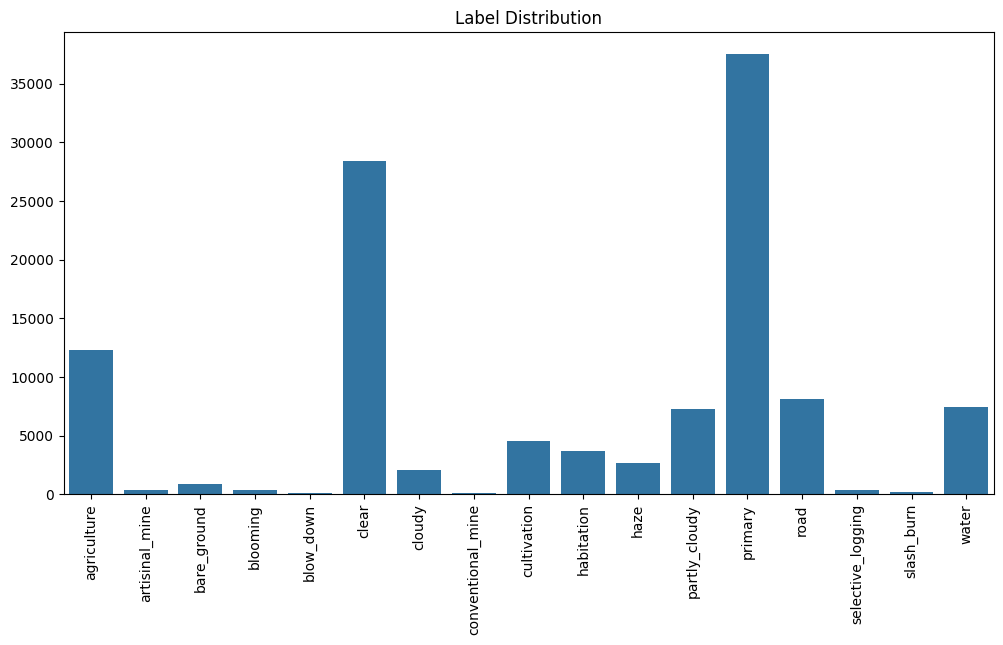

In [ ]:
# Split tags into separate columns
all_labels = np.unique(np.concatenate(train_df['tags'].apply(lambda x: x.split(' ')).values))
label_counts = {label: 0 for label in all_labels}
for tags in train_df['tags']:
    for tag in tags.split(' '):
        label_counts[tag] += 1

# Plot the distribution
plt.figure(figsize=(12, 6))
sns.barplot(x=list(label_counts.keys()), y=list(label_counts.values()))
plt.xticks(rotation=90)
plt.title('Label Distribution')
plt.show()

# Sample Images

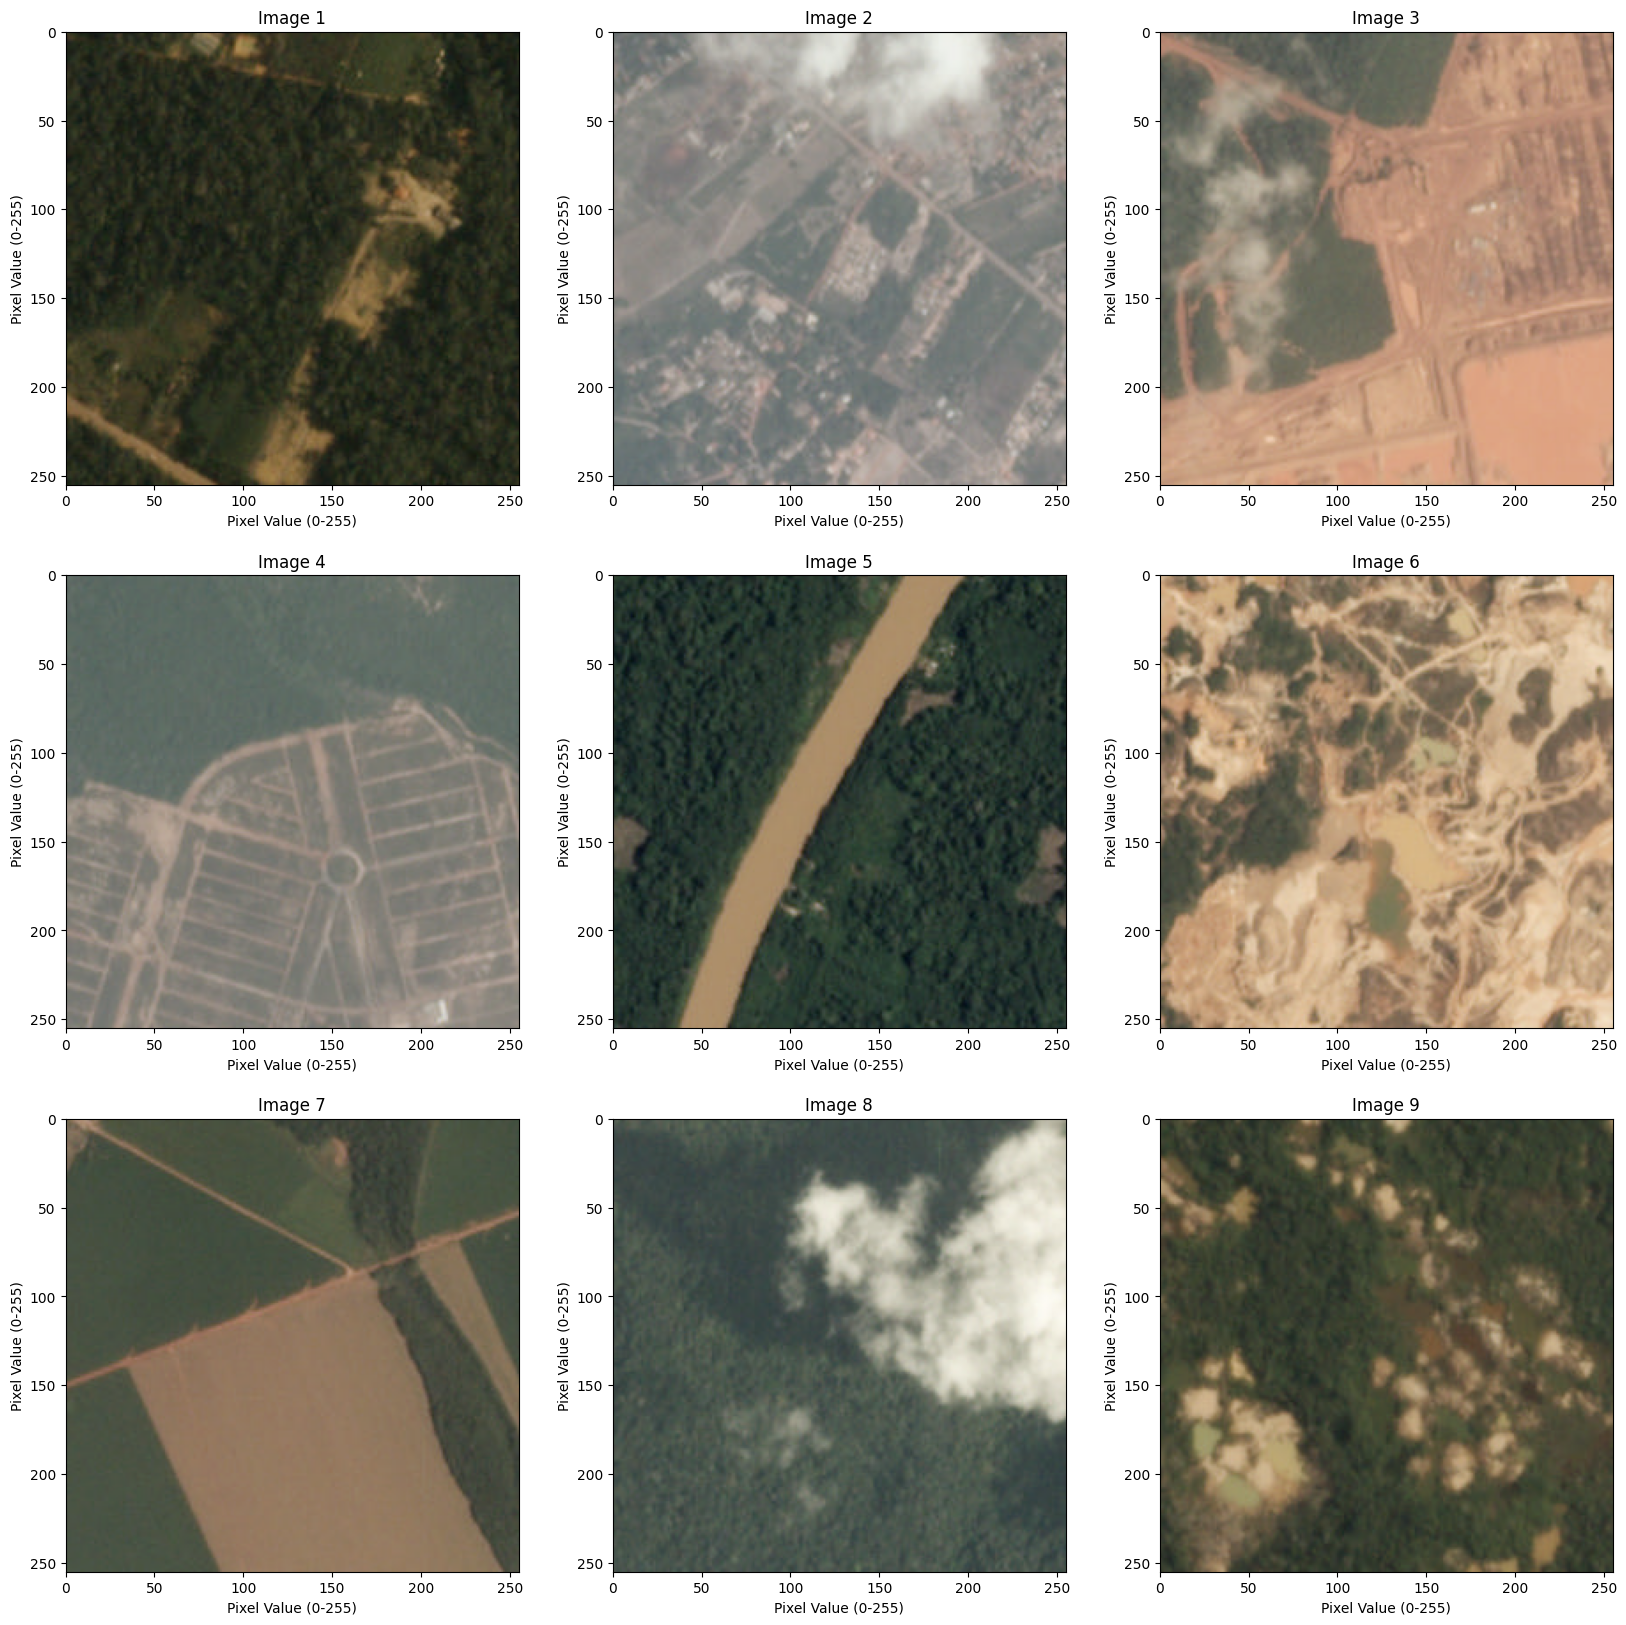

In [ ]:
# List of file paths to the images
image_paths = [
    "/content/train_123.jpg",
    "/content/train_230.jpg",
    "/content/train_24.jpg",
    "/content/train_258.jpg",
    "/content/train_26928.jpg",
    "/content/train_274.jpg",
    "/content/train_32.jpg",
    "/content/train_37.jpg",
    "/content/train_57.jpg"
]

# Let's view some images
plt.figure(figsize=(20, 20))

# Plot the images
for i, image_path in enumerate(image_paths):
    # Define subplot
    plt.subplot(330 + 1 + i)

    # Load image pixels
    image = imread(image_path)

    # Plot raw pixel data with extent
    plt.imshow(image, extent=[0, 255, 255, 0])
    plt.title(f"Image {i+1}")
    plt.xlabel('Pixel Value (0-255)')
    plt.ylabel('Pixel Value (0-255)')
    plt.axis('on')

# Show the figure
plt.show()


# Data Preprocessing

Split the labels in train_df to prepare them for multi-label classification.



In [5]:
train_df['labels'] = train_df['tags'].apply(lambda x: x.split(' '))

## Data Head 2

In [6]:
train_df.head()

,image_name,tags,labels
0,train_0,haze primary,"[haze, primary]"
1,train_1,agriculture clear primary water,"[agriculture, clear, primary, water]"
2,train_2,clear primary,"[clear, primary]"
3,train_3,clear primary,"[clear, primary]"
4,train_4,agriculture clear habitation primary road,"[agriculture, clear, habitation, primary, road]"


## Labels

In [7]:
#Unique labels
labels = train_df['labels'].explode().unique()
print(labels)

['haze' 'primary' 'agriculture' 'clear' 'water' 'habitation' 'road'
 'cultivation' 'slash_burn' 'cloudy' 'partly_cloudy' 'conventional_mine'
 'bare_ground' 'artisinal_mine' 'blooming' 'selective_logging' 'blow_down']


# Encode Labels (OHE)

In [8]:
# One hot encoding of labels
encoded_labels = train_df['tags'].str.get_dummies(sep=' ')
train_encoded = pd.concat([train_df, encoded_labels], axis=1)

# Adding .jpg extension to image_name column
train_encoded['image_name'] = train_encoded['image_name'].apply(lambda x: f"{x}.jpg")


## Data Head 3

In [9]:
train_encoded.head()

,image_name,tags,labels,agriculture,artisinal_mine,bare_ground,blooming,blow_down,clear,cloudy,conventional_mine,cultivation,habitation,haze,partly_cloudy,primary,road,selective_logging,slash_burn,water
0,train_0.jpg,haze primary,"[haze, primary]",0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
1,train_1.jpg,agriculture clear primary water,"[agriculture, clear, primary, water]",1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1
2,train_2.jpg,clear primary,"[clear, primary]",0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
3,train_3.jpg,clear primary,"[clear, primary]",0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4,train_4.jpg,agriculture clear habitation primary road,"[agriculture, clear, habitation, primary, road]",1,0,0,0,0,1,0,0,0,1,0,0,1,1,0,0,0


## Columns

In [10]:
# Define the columns starting from the third column
columns = train_encoded.columns[2:].tolist()

# Create a DataFrame with the list of columns
columns_df = pd.DataFrame(columns, columns=['Column_Name'])

# Print the DataFrame
print(columns_df)


          Column_Name
0              labels
1         agriculture
2      artisinal_mine
3         bare_ground
4            blooming
5           blow_down
6               clear
7              cloudy
8   conventional_mine
9         cultivation
10         habitation
11               haze
12      partly_cloudy
13            primary
14               road
15  selective_logging
16         slash_burn
17              water


# Dataset Split

In [14]:
# Split the data into train and validation sets
train_df, val_df = train_test_split(train_encoded, test_size=0.2, random_state=42)


# Image Data Generators

In [15]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
folder_path = "/content/drive/MyDrive/train_"


In [23]:
file_names = os.listdir(folder_path)

In [24]:
# Set up image data generators
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# Define image size and batch size
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Create train and validation generators
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory=folder_path,
    x_col='image_name',
    y_col=encoded_labels.columns.tolist(),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='raw'
)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    directory=folder_path,
    x_col='image_name',
    y_col=encoded_labels.columns.tolist(),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='raw'
)


Found 1570 validated image filenames.
Found 431 validated image filenames.


# Modelling

In [25]:
# Define the model architecture
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(encoded_labels.shape[1], activation='sigmoid')  # Output layer with sigmoid activation
])

# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Display model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)       0

# Model Training

In [26]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True)

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[early_stopping, model_checkpoint]
)


Epoch 1/20
50/50 [==============================] - 246s 5s/step - loss: 0.2774 - accuracy: 0.0000e+00 - val_loss: 0.2481 - val_accuracy: 0.0000e+00
Epoch 2/20
50/50 [==============================] - 231s 5s/step - loss: 0.2384 - accuracy: 0.0057 - val_loss: 0.2164 - val_accuracy: 0.0000e+00
Epoch 3/20
50/50 [==============================] - 237s 5s/step - loss: 0.2248 - accuracy: 0.0146 - val_loss: 0.2077 - val_accuracy: 0.0000e+00
Epoch 4/20
50/50 [==============================] - 227s 4s/step - loss: 0.2218 - accuracy: 0.0127 - val_loss: 0.2051 - val_accuracy: 0.0302
Epoch 5/20
50/50 [==============================] - 230s 5s/step - loss: 0.2125 - accuracy: 0.0261 - val_loss: 0.2013 - val_accuracy: 0.0139
Epoch 6/20
50/50 [==============================] - 235s 5s/step - loss: 0.2100 - accuracy: 0.0236 - val_loss: 0.1893 - val_accuracy: 0.0186
Epoch 7/20
50/50 [==============================] - 227s 5s/step - loss: 0.2032 - accuracy: 0.0280 - val_loss: 0.1871 - val_accuracy: 0.02

# Model Evaluation

In [32]:
# Evaluate the model
val_loss, val_accuracy = model.evaluate(val_generator)
print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')


14/14 [==============================] - 18s 1s/step - loss: 0.1871 - accuracy: 0.0209
Validation Loss: 0.18705831468105316, Validation Accuracy: 0.020881671458482742


# Training & Validation Curves

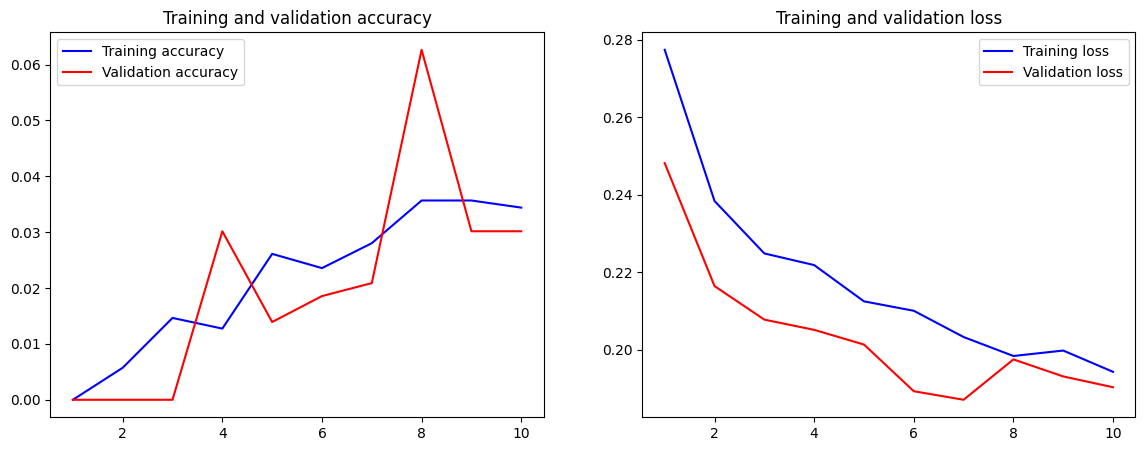

In [33]:
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

plot_training_history(history)


# Predictions

In [54]:
test_img_path = "/content/drive/MyDrive/test_"


In [56]:
!ls {test_img_path}

file_0.jpg     file_228.jpg  file_358.jpg  file_488.jpg  file_617.jpg  file_747.jpg  file_877.jpg
file_1000.jpg  file_229.jpg  file_359.jpg  file_489.jpg  file_618.jpg  file_748.jpg  file_878.jpg
file_1001.jpg  file_22.jpg   file_35.jpg   file_48.jpg	 file_619.jpg  file_749.jpg  file_879.jpg
file_100.jpg   file_230.jpg  file_360.jpg  file_490.jpg  file_61.jpg   file_74.jpg   file_87.jpg
file_101.jpg   file_231.jpg  file_361.jpg  file_491.jpg  file_620.jpg  file_750.jpg  file_880.jpg
file_102.jpg   file_232.jpg  file_362.jpg  file_492.jpg  file_621.jpg  file_751.jpg  file_881.jpg
file_103.jpg   file_233.jpg  file_363.jpg  file_493.jpg  file_622.jpg  file_752.jpg  file_882.jpg
file_104.jpg   file_234.jpg  file_364.jpg  file_494.jpg  file_623.jpg  file_753.jpg  file_883.jpg
file_105.jpg   file_235.jpg  file_365.jpg  file_495.jpg  file_624.jpg  file_754.jpg  file_884.jpg
file_106.jpg   file_236.jpg  file_366.jpg  file_496.jpg  file_625.jpg  file_755.jpg  file_885.jpg
file_107.jpg   file_23

In [65]:
# Load the sample submission file
sample_submission_df = pd.read_csv('/content/train_v2.csv')

In [66]:
sample_submission_df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [67]:
#  code to slice only 1002 rows

sample_submission_df_sliced = sample_submission_df.iloc[:1002, :]


In [68]:
sample_submission_df_sliced.shape

(1002, 2)

In [69]:
# Add '.jpg' extension to the image names
sample_submission_df_sliced['image_name'] = sample_submission_df_sliced['image_name'].apply(lambda x: f"{x}.jpg")

# Create a test data generator
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    sample_submission_df_sliced,
    directory=test_img_path,
    x_col='image_name',
    y_col=None,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode=None,
    shuffle=False
)

# Generate predictions for the test set
predictions = model.predict(test_generator, verbose=1)
predicted_labels = (predictions > 0.5).astype(int)

# Create a mapping for test data labels (assuming you have a list of labels):
test_labels = labels
labels_map = {i: label for i, label in enumerate(test_labels)}  # Create the mapping

predicted_tags = []
for pred in predicted_labels:
    tags = [labels_map[i] for i, val in enumerate(pred) if val]
    predicted_tags.append(" ".join(tags))

# Prepare the submission file
submission_df = pd.DataFrame({'image_name': sample_submission_df_sliced['image_name'], 'tags': predicted_tags})
submission_df.to_csv('submission.csv', index=False)


Found 0 validated image filenames.


ValueError: Asked to retrieve element 0, but the Sequence has length 0

# F2 Score Evaluation

In [70]:
def f2_score(y_true, y_pred):
    return fbeta_score(y_true, y_pred, beta=2, average='samples')

# Generate predictions on the validation set
val_preds = model.predict(val_generator)
val_preds_binary = (val_preds > 0.5).astype(int)
val_true = val_generator

# Calculate F2 score
val_true = val_preds_binary[:14]
f2 = f2_score(val_true, val_preds_binary)
print(f"Validation F2 score: {f2}")


14/14 [==============================] - 18s 1s/step


ValueError: Found input variables with inconsistent numbers of samples: [14, 431]